## The Lorenz chaotic attractor

This example shows the construction of a classic chaotic dynamical system: the Lorenz "butterfly" attractor.  The equations are:
        
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = x_0 (\rho - x_2) - x_1  \\\
\dot{x}_2 = x_0 x_1 - \beta x_2 
$$

Since $x_2$ is centered around approximately $\rho$, and since NEF ensembles are usually optimized to represent values within a certain radius of the origin, we substitute $x_2' = x_2 - \rho$, giving these equations:
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\\
\dot{x}_1 = - x_0 x_2' - x_1\\\
\dot{x}_2' = x_0 x_1 - \beta (x_2' + \rho) - \rho
$$

For more information, see http://compneuro.uwaterloo.ca/publications/eliasmith2005b.html "Chris Eliasmith. A unified approach to building and controlling spiking attractor networks. Neural computation, 7(6):1276-1314, 2005."

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

from matplotlib import rc, rcParams
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':7})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

import nengo
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [9]:
model = nengo.Network()
with model:
    num_intercepts = 4
    num_max_rates = 3
    num_encoders = 4
    num_neurons = np.int_(1 + num_encoders * num_max_rates * num_intercepts)
    encoders = np.concatenate(([[1,1,1]],
                               np.repeat([[1,1,1],
                                         [1,1,-1],
                                         [1,-1,1],
                                         [1,-1,-1]], num_max_rates*num_intercepts, axis=0)))
    intercepts = np.concatenate(([0], np.tile(np.repeat([-0.5,0,0.5,1], num_max_rates), 
                                              np.int_(num_encoders))))
    max_rates = np.concatenate(([0], np.tile(np.repeat([0.5,1,1.5], 1),
                                             np.int_(num_encoders*num_intercepts))))
    state = nengo.Ensemble(num_neurons, dimensions=3, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=1),
                       max_rates=max_rates,
                       encoders=encoders, radius=60.)
# with nengo.Simulator(model) as sim:
#     eval_points, activities = tuning_curves(state, sim)
# plt.plot(eval_points, activities, lw=2)
# plt.xlabel("Input signal")
# plt.ylabel("Firing rate (Hz)")

tau = 0.1
sigma = 10
beta = 8.0/3
rho = 28

def feedback(x):
    dx0 = -sigma * x[0] + sigma * x[1]
    dx1 = -x[0] * x[2] - x[1]
    dx2 = x[0] * x[1] - beta * (x[2] + rho) - rho
    
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

with model:
    #state = nengo.Ensemble(2000, 3, radius=60)
    #state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.Sinusoid(max_overall_rate=400))
    #state = nengo.Ensemble(100, 3, radius=60, neuron_type=nengo.neurons.RectifiedLinear())
    conn = nengo.Connection(state, state, function=feedback, synapse=tau)
    state_probe = nengo.Probe(state, synapse=tau)
    weight_probe = nengo.Probe(conn, 'weights')

with nengo.Simulator(model) as sim:
    sim.run(2/tau)
    # the nengo's weight matrix is sim.data[weight_probe][0,:,:], but that gives the best approx to (x0, x1, x2)
    # if you want the interconnection matrix you need to encode this vector using the encoders variable.
    weight_matrix = np.dot(encoders, sim.data[weight_probe][0,:,:])

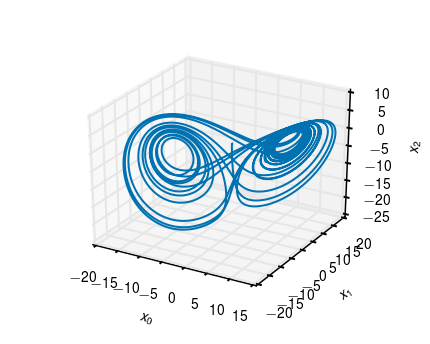

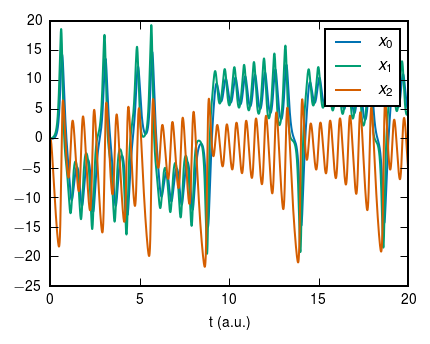

In [16]:
from mpl_toolkits.mplot3d import Axes3D

pp = PdfPages('lorenz_system_3d.pdf')
fig = plt.figure(0, figsize=(3,2.4), dpi=72)
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim.data[state_probe][:, 0],
        sim.data[state_probe][:, 1],
        sim.data[state_probe][:, 2])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
ax.dist=12
plt.tight_layout()
pp.savefig(bbox_inches='tight')
pp.close()

pp = PdfPages('lorenz_time_traces.pdf')
fig = plt.figure(1, figsize=(3,2.4), dpi=72)
for variable, label in zip(sim.data[state_probe].T, ['$x_0$', '$x_1$', '$x_2$']):
    plt.plot(sim.trange(), variable, label=label)
plt.legend()
plt.xlabel('t (a.u.)')
plt.tight_layout()
pp.savefig()
pp.close()


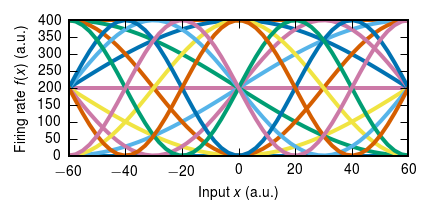

In [17]:
from nengo.utils.ensemble import tuning_curves
#1D enconders

model = nengo.Network()
with model:
    num_neurons = np.int_(4*4)
    encoders = np.tile([[1]], (np.int_(num_neurons),1))
    intercepts = np.tile([-0.5,0,0.5,1], np.int_(num_neurons/4))
    max_rates = np.repeat([0,0.5,1,1.5], np.int_(num_neurons/4))
    state = nengo.Ensemble(num_neurons, dimensions=1, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=1),
                       max_rates=max_rates,
                       encoders=encoders, radius=60.)
    state_probe = nengo.Probe(state)
    
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(state, sim)
    
with PdfPages('tuning_curves.pdf') as pp:
    fig = plt.figure(2, figsize=(3,1.5), dpi=72)
    plt.plot(eval_points, activities, lw=2)
    plt.xlabel("Input $x$ (a.u.)")
    plt.ylabel("Firing rate $f(x)$ (a.u.)")
    plt.tight_layout()
    pp.savefig()

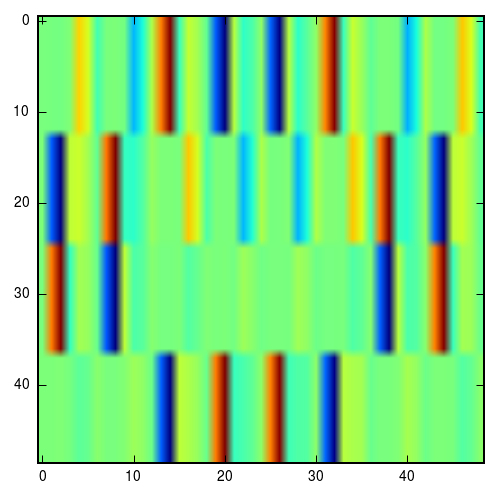

In [5]:
plt.imshow(weight_matrix)